# EY EXTRA SEATS and CABIN UPGRADE conversion

In [ ]:
!pip install ipython-sql

In [ ]:
#!pip install -U numpy

In [ ]:
#!python --version

In [ ]:
#import sklearn
#print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [1]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import learning_curve

%matplotlib inline


## Read Data

In [2]:
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
import json
import boto3
import base64

%load_ext sql
 
%config SqlMagic.displaylimit = 5
credfile = '../../redshift_creds_template.json.nogit'

with open(credfile) as fh:
    creds = json.loads(fh.read())
 
%config SqlMagic.displaylimit = 5


from sagemaker import get_execution_role
session = boto3.session.Session()
kms = session.client('kms')
encrypted_user = creds['username']
encrypted_pass = creds['password']
binary_data = base64.b64decode(encrypted_user)
meta = kms.decrypt(CiphertextBlob=binary_data)
user = meta[u'Plaintext']
binary_data = base64.b64decode(encrypted_pass)
meta2 = kms.decrypt(CiphertextBlob=binary_data)
passwd = meta2[u'Plaintext']
connect_to_db = 'postgresql+psycopg2://' + \
                user.decode() + ':' + passwd.decode() + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];

engine = create_engine(connect_to_db)
con = engine.connect()




/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
query="""
SELECT * FROM ml_prep.gauthier_offer_load_all_ey_2019_2020_dataset where event_time>'2019-10-01T00:00:00Z'; ;
"""
df = pd.read_sql_query(query, con)
df.head(3)


event_time                          request_id  partner_id  \
0  2019-11-01T20:09:25Z  f6B4H3L8Kw9xa8RIbUzrj0KJ1UhsF0TOna          11   
1  2019-11-01T20:09:25Z  f6B4H3L8Kw9xa8RIbUzrj0KJ1UhsF0TOna          11   
2  2019-10-06T01:17:39Z  BKr6roe2KovE5vilPT7ifDenZjVp2s6jKe          11   

  origin destination  flight_number departure_date departure_time from_cabin  \
0    AUH         HYD            274     2019-11-03          21:50    ECONOMY   
1    ORD         AUH            150     2019-11-02          21:25    ECONOMY   
2    JFK         AUH            100     2019-10-13          22:55    ECONOMY   

    upgrade_type  ... last_email_opened_time  email_opened_count  \
0       BUSINESS  ...    2019-11-28 23:06:53                  70   
1       BUSINESS  ...    2019-11-28 23:06:53                  70   
2  A380_BUSINESS  ...    2019-07-13 20:14:07                  14   

  first_email_clicked_time last_email_clicked_time email_clicked_count  \
0      2019-10-31 19:08:31     2019-11-01 20:09:17                   4   
1      2019-10-31 19:08:31     2019-11-01 20:09:17                   4   
2      2019-07-08 12:22:39     2019-07-13 20:14:59                   4   

   offer_amount_usd  offer_amount_total_usd offer_quantity offer_customer_id  \
0               NaN                     NaN            NaN               NaN   
1               NaN                     NaN            NaN               NaN   
2               NaN                     NaN            NaN               NaN   

  offer_type  
0     NO_BID  
1     NO_BID  
2     NO_BID  

[3 rows x 50 columns]

# Feature Engineering

In [4]:
#drop non relevant fields
df = df.drop(['distance_unit', 'request_id', 'slider_min','slider_max', 'slider_step', 'pnr', 
         'instant_upgrade_eligibility_reason', 'eligibility_reason', 'instant_upgrade_eligibility','slider_step'
        ], axis=1)



In [5]:
# compute some time-related features
# this takes some time
df['departure_hour'] = pd.to_datetime(df['departure_time']).apply(lambda x: x.hour)
df['departure_day_of_week']= pd.to_datetime(df['departure_date']).apply(lambda x: x.dayofweek)
df['departure_month']= pd.to_datetime(df['departure_date']).apply(lambda x: x.month)
df['event_day_of_week']= pd.to_datetime(df['event_time']).apply(lambda x: x.dayofweek)
df['event_hour']= pd.to_datetime(df['event_time']).apply(lambda x: x.hour)
df['event_year']= pd.to_datetime(df['event_time']).apply(lambda x: x.year)

df['event_month']= pd.to_datetime(df['event_time']).apply(lambda x: x.month)
df['origin_destination'] = df['origin']+ df['destination']
df["days_before_departure"] =(pd.to_datetime(df["departure_date"])-pd.to_datetime(df["event_time"]).dt.tz_localize(None)).apply(lambda x: x.days)
df["days_since_first_offer_load"] = (pd.to_datetime(df["event_time"]) - pd.to_datetime(df["first_offer_load_time"])).apply(lambda x: x.days)
df["first_offer_load_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["first_offer_load_time"]).dt.tz_localize(None)).apply(lambda x: x.days)

df["first_email_sent_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["first_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["last_email_sent_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["last_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_first_email_sent"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_last_email_sent"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["last_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)

df["first_email_opened_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["first_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["last_email_opened_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["last_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_first_email_opened"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_last_email_opened"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["last_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)

df["first_email_clicked_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["first_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["last_email_clicked_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["last_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_first_email_clicked"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_last_email_clicked"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["last_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)

df["days_between_first_last_email_sent"] = (pd.to_datetime(df["last_email_sent_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_between_first_last_email_opened"] = (pd.to_datetime(df["last_email_opened_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_between_first_last_email_clicked"] = (pd.to_datetime(df["last_email_clicked_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)



In [6]:
df.head(3)

event_time  partner_id origin destination  flight_number  \
0  2019-11-01T20:09:25Z          11    AUH         HYD            274   
1  2019-11-01T20:09:25Z          11    ORD         AUH            150   
2  2019-10-06T01:17:39Z          11    JFK         AUH            100   

  departure_date departure_time from_cabin   upgrade_type  \
0     2019-11-03          21:50    ECONOMY       BUSINESS   
1     2019-11-02          21:25    ECONOMY       BUSINESS   
2     2019-10-13          22:55    ECONOMY  A380_BUSINESS   

  first_offer_load_time  ...  last_email_opened_days_before_departure  \
0  2019-10-31T19:08:41Z  ...                                      -26   
1  2019-10-31T19:08:41Z  ...                                      -27   
2  2019-07-08T12:22:48Z  ...                                       91   

  days_since_first_email_opened days_since_last_email_opened  \
0                           117                          -28   
1                           117                          -28   
2                            89                           84   

   first_email_clicked_days_before_departure  \
0                                          2   
1                                          1   
2                                         96   

   last_email_clicked_days_before_departure days_since_first_email_clicked  \
0                                         1                              1   
1                                         0                              1   
2                                        91                             89   

  days_since_last_email_clicked days_between_first_last_email_sent  \
0                             0                                118   
1                             0                                118   
2                            84                                  2   

  days_between_first_last_email_opened  days_between_first_last_email_clicked  
0                                  144                                      1  
1                                  144                                      1  
2                                    5                                      5  

[3 rows x 67 columns]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416373 entries, 0 to 2416372
Data columns (total 67 columns):
 #   Column                                     Dtype         
---  ------                                     -----         
 0   event_time                                 object        
 1   partner_id                                 int64         
 2   origin                                     object        
 3   destination                                object        
 4   flight_number                              int64         
 5   departure_date                             object        
 6   departure_time                             object        
 7   from_cabin                                 object        
 8   upgrade_type                               object        
 9   first_offer_load_time                      object        
 10  offer_load_count                           int64         
 11  currency                                   object        
 12  

# Feature Encoding

In [8]:
# for random forest, no need to one-hot-encode
def label_encode_categorical(df, columns):
    train_df_fact = df.copy()
    for column in columns:
        print('label encoding',column,'...')
        encoder = preprocessing.LabelEncoder()
        encoder.fit(train_df_fact[column])
        train_df_fact[column+'_encoded'] = encoder.transform(train_df_fact[column])
    return train_df_fact


In [9]:
# label-encode categories
df= label_encode_categorical(df,['origin','channel_source','destination','origin_destination','language','point_of_sale','equipment'])

label encoding origin ...
label encoding channel_source ...
label encoding destination ...
label encoding origin_destination ...
label encoding language ...
label encoding point_of_sale ...
label encoding equipment ...


# Label encode

In [10]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(df['offer_type'])
df['offer_type_encoded'] = label_encoder.transform(df['offer_type'])

In [11]:
label_encoder.classes_

array(['CABIN_UPGRADE', 'EXTRA_SEAT', 'NO_BID'], dtype=object)

In [12]:
df.head(3)

event_time  partner_id origin destination  flight_number  \
0  2019-11-01T20:09:25Z          11    AUH         HYD            274   
1  2019-11-01T20:09:25Z          11    ORD         AUH            150   
2  2019-10-06T01:17:39Z          11    JFK         AUH            100   

  departure_date departure_time from_cabin   upgrade_type  \
0     2019-11-03          21:50    ECONOMY       BUSINESS   
1     2019-11-02          21:25    ECONOMY       BUSINESS   
2     2019-10-13          22:55    ECONOMY  A380_BUSINESS   

  first_offer_load_time  ...  days_between_first_last_email_opened  \
0  2019-10-31T19:08:41Z  ...                                   144   
1  2019-10-31T19:08:41Z  ...                                   144   
2  2019-07-08T12:22:48Z  ...                                     5   

  days_between_first_last_email_clicked origin_encoded  \
0                                     1              4   
1                                     1             66   
2                                     5             41   

   channel_source_encoded  destination_encoded origin_destination_encoded  \
0                       9                   35                         38   
1                       9                    4                        144   
2                      35                    4                        118   

  language_encoded point_of_sale_encoded equipment_encoded  offer_type_encoded  
0               20                    24                 7                   2  
1               20                    24                 5                   2  
2               20                    51                 4                   2  

[3 rows x 75 columns]

In [13]:
columns_for_training= [
                       # departure time
                       'departure_hour',
                       'departure_day_of_week',
                       'departure_month',
                       # event time
                       'event_hour',
                       'event_day_of_week',
                       'event_month',
                           'event_year',
                       'days_before_departure',
                       # route
                       'origin_encoded', 
                       'destination_encoded',
                       'origin_destination_encoded',
                       'duration', 
                       'distance', 
                       # the rest
                       'channel_source_encoded',
                       'language_encoded',
                       'pax',
                       'point_of_sale_encoded',
                       'equipment_encoded',
                       # slider
                       'slider_max_usd',        
                       'slider_min_usd',        
                       'slider_start_usd',  
                       # previous offer loads
                        #'offer_load_count',
                        #'days_since_first_offer_load',
                        #'first_offer_load_days_before_departure',
                       # email 
                        'first_email_sent_days_before_departure',
                        'last_email_sent_days_before_departure',
                        'days_since_first_email_sent',
                        'days_since_last_email_sent',
                        'first_email_opened_days_before_departure',
                        'last_email_opened_days_before_departure',
                        'days_since_first_email_opened',
                        'days_since_last_email_opened',
                        'first_email_clicked_days_before_departure',
                        'last_email_clicked_days_before_departure',
                        'days_since_first_email_clicked',
                        'days_since_last_email_clicked',
                        'days_between_first_last_email_sent',
                        'days_between_first_last_email_opened',
                        'days_between_first_last_email_clicked',
                        'email_sent_count',
                        'email_opened_count',
                        'email_clicked_count',
                       # target
                        'offer_type_encoded',
                      ]

df = df[columns_for_training]

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416373 entries, 0 to 2416372
Data columns (total 40 columns):
 #   Column                                     Dtype  
---  ------                                     -----  
 0   departure_hour                             int64  
 1   departure_day_of_week                      int64  
 2   departure_month                            int64  
 3   event_hour                                 int64  
 4   event_day_of_week                          int64  
 5   event_month                                int64  
 6   event_year                                 int64  
 7   days_before_departure                      int64  
 8   origin_encoded                             int64  
 9   destination_encoded                        int64  
 10  origin_destination_encoded                 int64  
 11  duration                                   int64  
 12  distance                                   int64  
 13  channel_source_encoded                    

In [15]:
df.head(4)

departure_hour  departure_day_of_week  departure_month  event_hour  \
0              21                      6               11          20   
1              21                      5               11          20   
2              22                      6               10           1   
3              21                      3               10          17   

   event_day_of_week  event_month  event_year  days_before_departure  \
0                  4           11        2019                      1   
1                  4           11        2019                      0   
2                  6           10        2019                      6   
3                  6           10        2019                      3   

   origin_encoded  destination_encoded  ...  \
0               4                   35  ...   
1              66                    4  ...   
2              41                    4  ...   
3               4                   75  ...   

   last_email_clicked_days_before_departure  days_since_first_email_clicked  \
0                                         1                               1   
1                                         0                               1   
2                                        91                              89   
3                                         3                               0   

   days_since_last_email_clicked  days_between_first_last_email_sent  \
0                              0                                 118   
1                              0                                 118   
2                             84                                   2   
3                              0                                  92   

   days_between_first_last_email_opened  \
0                                   144   
1                                   144   
2                                     5   
3                                    86   

   days_between_first_last_email_clicked  email_sent_count  \
0                                      1                19   
1                                      1                19   
2                                      5                 6   
3                                      0                 9   

   email_opened_count  email_clicked_count  offer_type_encoded  
0                  70                    4                   2  
1                  70                    4                   2  
2                  14                    4                   2  
3                   9                    1                   2  

[4 rows x 40 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f38d10dd9e8>]],
      dtype=object)

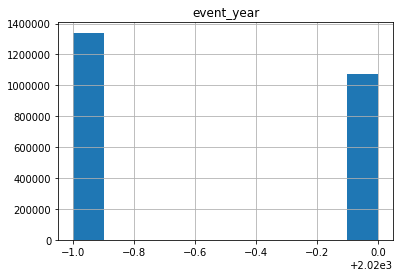

In [16]:
# we could use month to split train/test data
pd.DataFrame.hist(df,column='event_year')

# Model Training & Evaluation

In [17]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cbar=False)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [18]:
def train_and_evaluate(df_to_train, plot_learning_curves=False, limit=None, split_on_time=False):
    # X-validation
    from sklearn.preprocessing import label_binarize
    from sklearn.multiclass import OneVsRestClassifier
    
    if limit is not None:
        #pick them randomly
        df_to_train = df_to_train.sample(n=limit)

    random_forest =  OneVsRestClassifier(RandomForestClassifier(n_estimators=100))
    X = df_to_train.drop("offer_type_encoded", axis=1)
    y_raw = df_to_train["offer_type_encoded"]
    
    y = label_binarize(y_raw, classes=[0, 1, 2])

    n_classes = y.shape[1]
    
    if split_on_time:
        X_train = X[X["event_year"] == 2019 ].drop("event_year", axis=1)
        y_train = y[X["event_year"] == 2019]
        X_test = X[X["event_year"] == 2020].drop("event_year", axis=1)
        y_test = y[X["event_year"] == 2020]
        print('split on time')
    else:
        X = X.drop("event_year", axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)
        print('random split')

    # train
    print('training on', str(len(X_train)), 'rows...')
    random_forest.fit(X_train, y_train)
    print('training is done!')
    print('testing on', str(len(X_test)), 'rows...')

    # predict
    y_test_proba = random_forest.predict_proba(X_test)
    y_test_predict = random_forest.predict(X_test)

    #print('y_test_proba',y_test_proba)
    #print('y_test_predict',y_test_predict)
    # evaluation metrics

    roc_auc = dict()
    
    colors = ['red', 'blue', 'green']
    
    plt.figure(figsize=(16,9))
    for i,color in zip(range(n_classes),colors):
        fpr, tpr, _ = metrics.roc_curve(y_test[:, i], y_test_proba[:, i])
        plt.title('ROC')
        plt.plot([0, 1], [0,1], 'k--')
        roc_auc_for_one_class=metrics.auc(fpr, tpr)
        roc_auc[i] = roc_auc_for_one_class
        plt.plot(fpr, tpr,marker='.',color=color, label='{0} (AUC = {1:0.2f})'.format(label_encoder.classes_[i], roc_auc_for_one_class))
        plt.legend(loc="center right")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
    roc_auc = metrics.roc_auc_score(y_test,y_test_proba,multi_class="ovr")
    
    print('global roc_auc',roc_auc)
    
    
    plt.figure(figsize=(16,9))
    for i,color in zip(range(n_classes),colors):
        precisions, recalls, thresholds = metrics.precision_recall_curve(y_test[:, i], y_test_proba[:, i])
        plt.title('Precision-Recall')
        roc_pr_for_one_class=metrics.auc(recalls, precisions)
        plt.plot(recalls, precisions,marker='.',color=color, label='{0} (AUC = {1:0.2f})'.format(label_encoder.classes_[i], roc_pr_for_one_class))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc="center right")
        # proportion of positive examples
        #no_skill = len(y[y==1]) / len(y)
        #plt.plot([0, 1], [no_skill, no_skill], linestyle='--')

    #print('precisions',precisions)
    #print('recalls',recalls)
    #print('thresholds',thresholds)

    precision,recall,f1,support = metrics.precision_recall_fscore_support(y_test,y_test_predict)

    for i in range(n_classes):
        print('#### CLASS',label_encoder.classes_[i],'####')
        print('precision', precision[i])
        print('recall', recall[i])
        print('f1', f1[i])
        print('support', support[i])

    cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_test_predict.argmax(axis=1))
    print_confusion_matrix(cm, label_encoder.classes_)

    
    for i in range(n_classes):
        features = X_train.columns
        importances = random_forest.estimators_[i].feature_importances_
        indices = np.argsort(importances)[::-1]
        print('# EY offer type prediction. Feature importance for',label_encoder.classes_[i])
        for feature,importance in zip(features[indices],importances[indices]):
            print(feature+','+str(importance))
    
        # Plot the impurity-based feature importances of the forest
        plt.figure(figsize=(16,9))
        plt.title('Feature Importances for class '+ label_encoder.classes_[i])
        plt.bar(range(len(indices)), importances[indices], color='b', align='center')   
        plt.xticks(range(X_train.shape[1]), features[indices],rotation=90)
    
    if plot_learning_curves:
        scoring = 'roc_auc'
        print('Computing Learning curves...')
        train_sizes, train_scores, test_scores = \
                learning_curve(random_forest, X, y, train_sizes=np.linspace(0.1, 1.0, 5), scoring=scoring, cv=2)

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(16,9))
        # Plot learning curve
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        plt.legend(loc="best")
        plt.xlabel("Training examples")
        plt.ylabel(scoring)
        plt.title("Learning Curves")


        print(train_sizes)
        print(train_scores)
        print(test_scores)


In [ ]:
# run with a smaller subset to sanity check + the learning curves
train_and_evaluate(df,plot_learning_curves=False,limit=20000)

In [ ]:
# run with a lot of data
train_and_evaluate(df,plot_learning_curves=False,limit=1000000)

In [ ]:
# run with all data
train_and_evaluate(df,plot_learning_curves=False,limit=2000000)

split on time
training on 554538 rows...
training is done!
testing on 445462 rows...
global roc_auc 0.8432083118923144
#### CLASS CABIN_UPGRADE ####
precision 0.7352941176470589
recall 0.0034073872154831673
f1 0.00678334011667345
support 7337
#### CLASS EXTRA_SEAT ####
precision 0.0
recall 0.0
f1 0.0
support 2269
#### CLASS NO_BID ####
precision 0.9785445499205188
recall 0.9999449359421461
f1 0.9891290039988925
support 435856
# EY offer type prediction. Feature importance for CABIN_UPGRADE
event_hour,0.09400125775527003
slider_min_usd,0.06741184735253453
days_before_departure,0.0669572025574369
slider_start_usd,0.059055501274921235
slider_max_usd,0.055674873841802856
event_day_of_week,0.05490829668545731
departure_day_of_week,0.05345307753907817
duration,0.04040197919836886
departure_hour,0.03488194644455107
origin_destination_encoded,0.03206336533107924
channel_source_encoded,0.02918081826477256
distance,0.028767680892805455
point_of_sale_encoded,0.024886041808319367
pax,0.02371315478

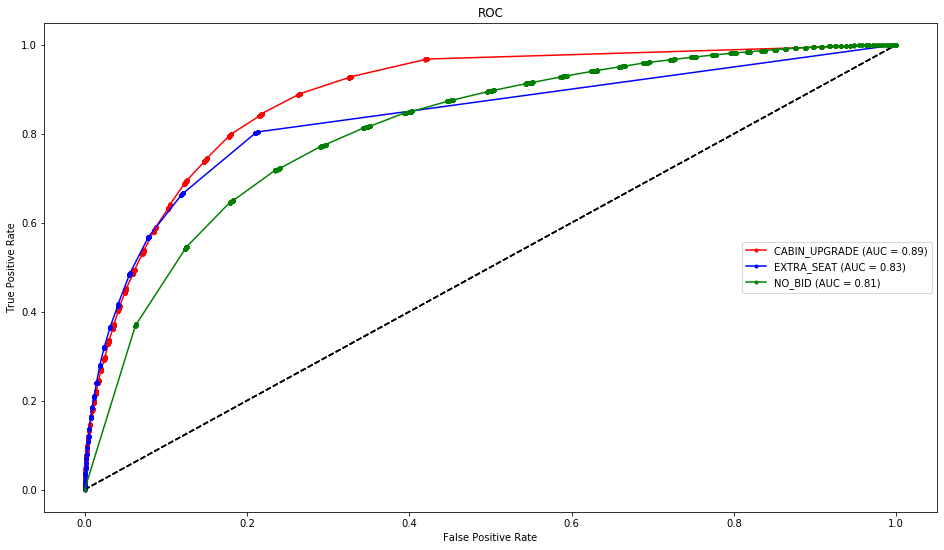

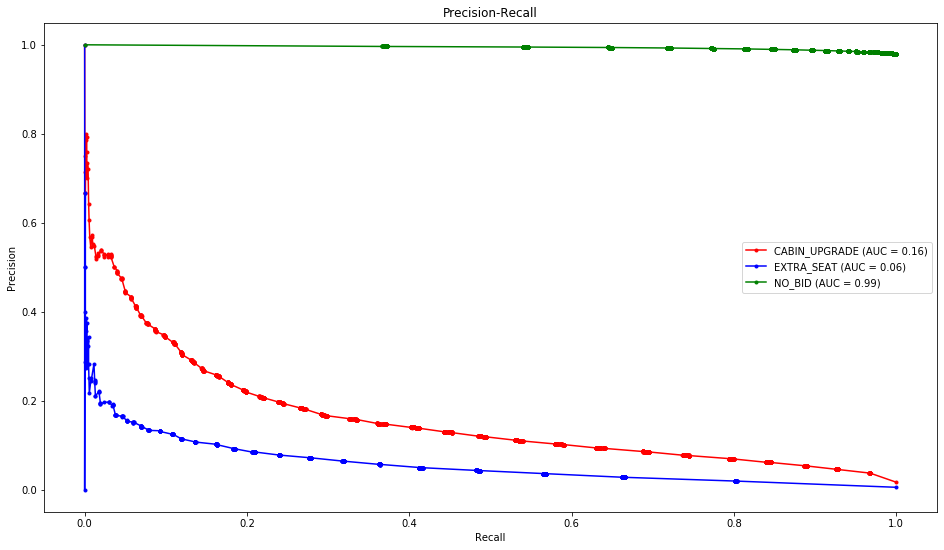

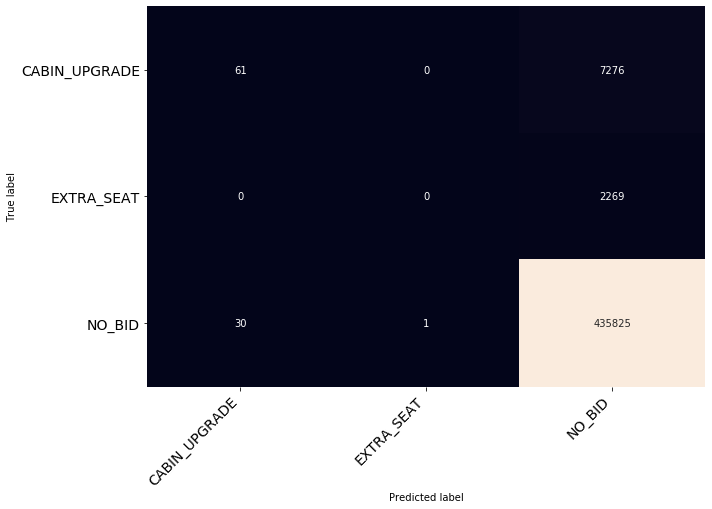

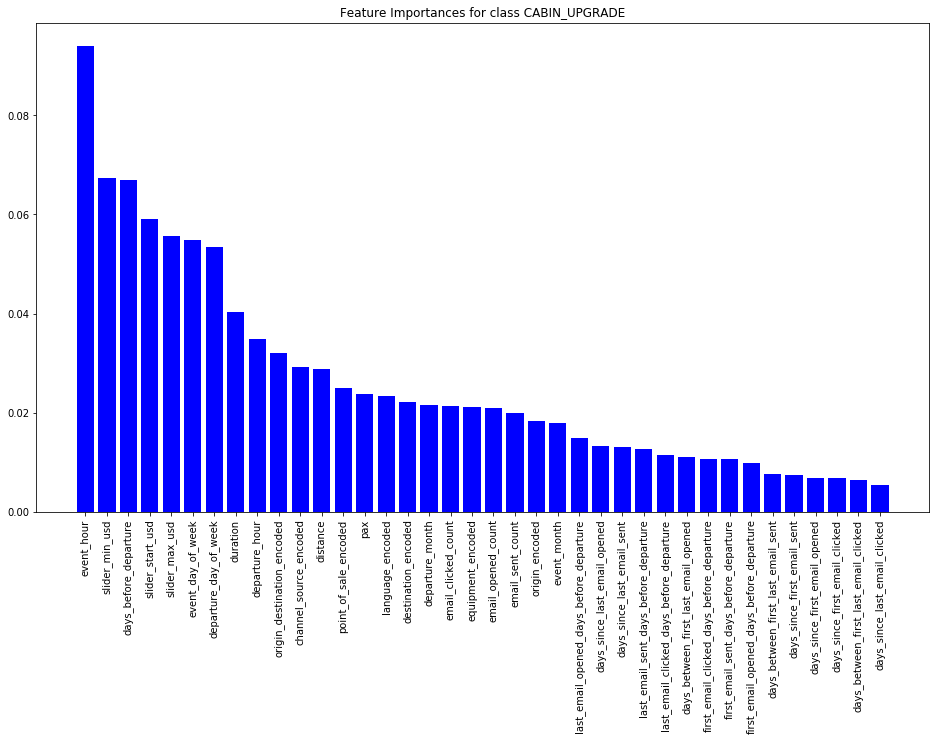

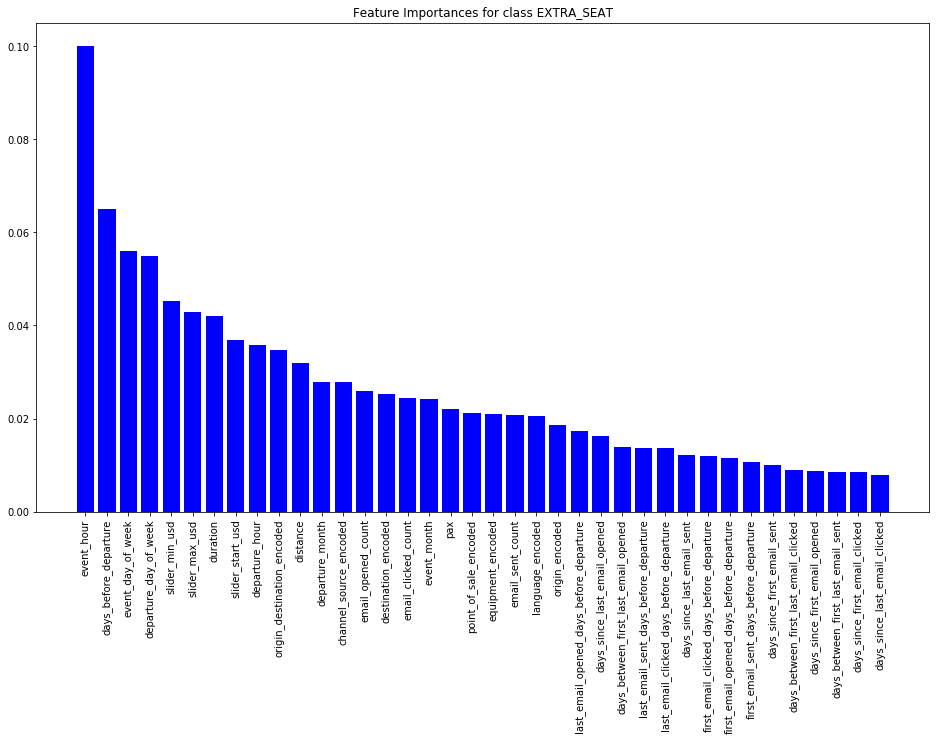

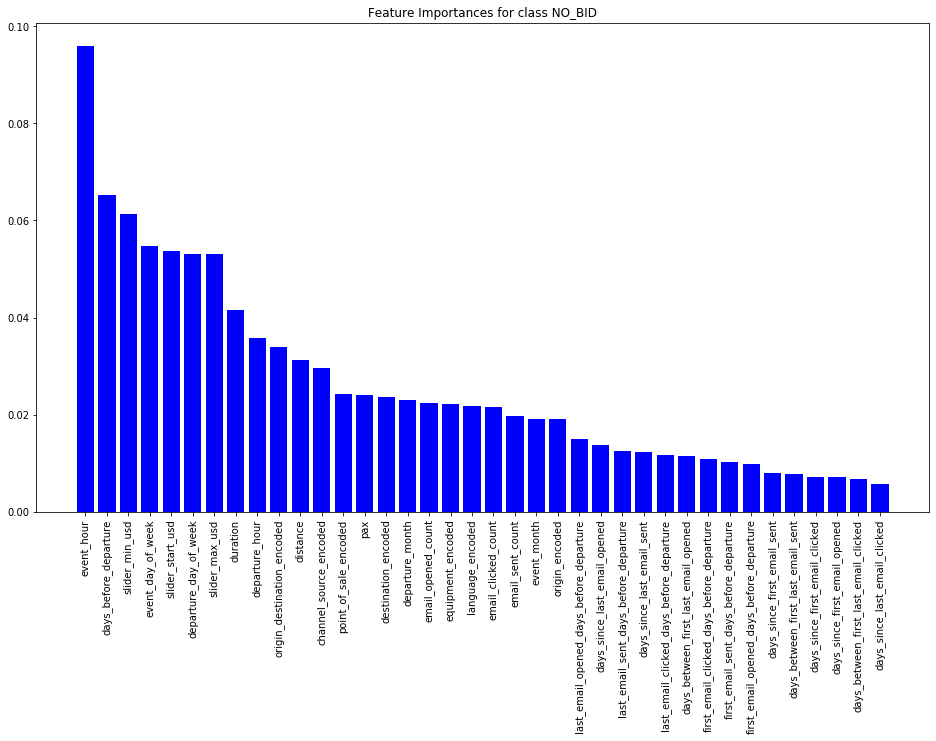

In [19]:
# run with a lot of data split on time (year 2019 vs 2020)
train_and_evaluate(df,plot_learning_curves=False,limit=1000000, split_on_time=True)